# Using the logistic encoder to represent any metaGGA exchange functional in LibXC with just 1 parameter

Take any metaGGA functional from libXC (exchange and/or correlation) and represent its enhancement factor on a 2D grid (containing npoints*npoints). Then find the initial conditon $\alpha$ such that the enhancement factor can be reproduced using the logistic decoder:

$$
\begin{equation}
f(x) = \sin^2 ( 2^{x\beta} \arcsin \sqrt \alpha )
\end{equation}
$$

with $\beta$ controlling the accuracy of the encoding process (beta = 8 gives shorter parameters, but noisier interpolation. beta = 10 or above gives mostly smooth interpolations.
The accuracy of the interpolation depends on the number of grid points (npoints).

Two options are available:

1. calccorr to turn on/off the inclusion of the correlation functional (interpretation for the exchange functional is simpler, since it is only a 2-dimensional plot. See also the DFT_gga_exchange.ipynb for a similar situation without the complications of the code for the 3-dimensional fit for the correlation)
2. calcenh to divide the functional by the LDA exchange (the exact exchange for a U.E.G.). Turning this option on  gives better interpolation results, since the 2-dimensional fit is only on the enhancement factor (which is better behaved than the full xc energy density).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylibxc as pylibxc
import scipy.interpolate as spint

#Setting the most important parameters, the number of points and the functional. beta is set in helperFunctions.py
npoints=20 #very slow if going > 20
functional='MGGA_X_SCAN'


#inf is a small number to avoid discontinuities at u=1 (s=infinity) and tau=0:
inf=0.000000001

In [2]:
#reading the functionals from libxc

#defining the transformation of s into u, gamma is a multiplicative factor in front of s (in this case gamma=1 always)    
gamma=1
ss = lambda u,g: (u/(g+g*inf-g*u))**(1/2);
ww = lambda w,rho: (1-w)/(1+w+inf)*(3/10*(3*np.pi**2)**(2/3)*rho**(5/3))

#select libxc functional
flda = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func = pylibxc.LibXCFunctional(functional, "unpolarized")

rss=0.5
#density values, this term will be cancelled out when calculating the enhancement factor, so it effectively doesn't matter, but we need a number here to comply with LibXC requests
rhoval=3/(4*np.pi*(rss**3))

patch=100
fxval = []
for x in range(npoints+1): #loop over tau, via w[-1,1]
    tau=ww(-1+2*x/npoints,rhoval)   
    for y in range(npoints+1): #loop over gamma via u[0,1]
        spv=ss(y/npoints,gamma)
        gam=(rhoval**(4/3)*spv/(24*np.pi**2)**(-1/3))**2

        inp = {}
        inp["rho"] = [rhoval]
        inp["sigma"] = [gam]
        inp["tau"] = [tau]
    
        fval = func.compute(inp)
        lval = flda.compute(inp)

        zk=np.ndarray.flatten(list(fval.values())[0])
        zlda=np.ndarray.flatten(list(lval.values())[0])        
        zk = zk/zlda;
        fxval.append(zk);

#make sure that fxval fills a 1d-array
fxval=np.concatenate(fxval).ravel()

#reshape to a matrix (2d-array)
fxval3d=fxval.reshape(-1,npoints+1)

#workaround to avoid functional that diverge at s=infinity to explode at u=1. If we don't do this, the fit error will be dominated by this last point
rescale=False;
for nn in range((npoints+1)**2):
    if abs(fxval[nn])>100:
        fxval[nn]=fxval[nn-1]*2
        rescale=True
if rescale==True:
    print('Warning: This xc functional diverges at s=infinity.')
    print('Applying a patch to avoid explosion of interpolation errors') 

#print(fxval)
#print(fxval3d)


In [3]:
#select one array/functional:
xxs=fxval

#normalize all data to y=[0,1] interval

from sklearn.preprocessing import MinMaxScaler

allData = np.array(xxs).reshape(-1, 1)
normalizerModel = MinMaxScaler().fit(allData)
xs = normalizerModel.transform(allData)
originalDataSize = allData.shape[0]
xs3d = xs.reshape(-1,npoints+1)

#print('alldata = %s' % xxs)
#print('alldata = %s' % xs)
#print('alldata = %s' % xs3d)

In [4]:
#Call the logistic encoder to encode data to 1 parameter (beta is set in helperFunctions and is defaulted at 8)
from helperFunctions import *

decimalInitial = findInitialCondition(xs)

#Printing the single parameter:
print(decimalInitial)
print('\nbeta = %d' % beta)
print('number of decimal digits = %d' % len(str(decimalInitial)))


significance = 5292 bits ; 1592 digits (base-10) ; ratio = 3.324

0.62765160302990090558090684322030219063453918535756925757838610428977695066225165077193973035069055756263147654624096476968151256682193098096569471270381640125176853490947694989741205623117254065011015334495553340398020212945451389342653254617205052494430643648801714855122515474991214674075884555234955582580450046253280070119696565628256656176665973547124528968918079788120967446780892358092352426497727593787649766831919145640482416499570564782081066349156602349249933879932026195308632391074453454386057004462127155767903098274262233048256174141784991815016362623692657877174653505536891256455933050254673382747334238767870546082209299353992553470198341514966323364690019324954687159775478768963029276769292143933795569871987667078774932569656721477386810391624085564104334027643674321616768812050569912453156193144488152941264835577080775961990426621533279107918495349058470745803561157463870714249230242813187184661079808946983

In [5]:
#Call the inverse transformation for decode the data
decodedValues = generateData(decimalInitial, originalDataSize)

#print('data before transformation = %s' % decodedValues)

In [6]:
#Rescale the values back to the original y range

dvR = np.array(decodedValues).reshape(-1, 1)
decodedValuesR = normalizerModel.inverse_transform(dvR)
decodedValuesR = np.concatenate(decodedValuesR).ravel()

# 3d matrices
decodedValues3d = dvR.reshape(-1,npoints+1)
decodedValuesR3d = decodedValuesR.reshape(-1,npoints+1)

#print('data after transformation = %s' % decodedValues)

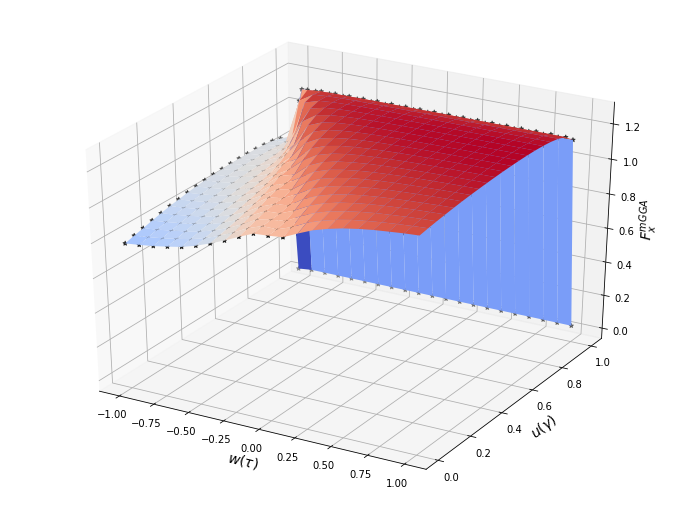

In [7]:
#plotting the original and decoded data
from mpl_toolkits.mplot3d import Axes3D

# define x and y scale 
xaxis=[] #tau before rescaling [-1,1]
for x in range(npoints+1):
    xaxis.append(-1+2*x/npoints);
yaxis=[] #gamma before rescaling [0,1]
for y in range(npoints+1):
    yaxis.append(y/npoints);
    
#inverting the axis because caonstant values of tau are in one row of the matrix (not column)
Y, X = np.meshgrid(yaxis, xaxis)
Z = decodedValuesR3d

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(X, Y, Z, color='black', marker='*')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')

ax.set_xlabel(r'$w(\tau)$', size=14)
ax.set_ylabel(r'$u(\gamma)$', size=14)
ax.set_zlabel(r'$F_{x}^{mGGA}$', size=14)

#ax.set_zlim(bottom=-4,top=4)

#plt.savefig('mGGA_X_3D.png',dpi=480,transparent=True)


plt.show()

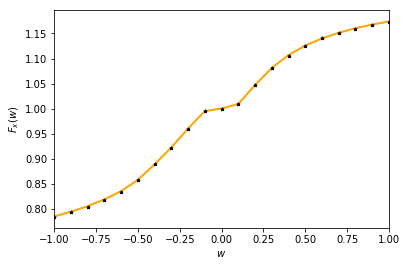

In [8]:
#plotting the original and decoded data in 1d, slice at constant s
#Plot the interpolation vs the functional and the original points

#selecting the value of s at which to slice (u before the scaling back so sval=u=[0,1]):
sval=0
if sval > 1:
    sval=1
ncol=sval*npoints
ncol=int(ncol)
sfromu=  (yaxis[ncol]/(1+inf-yaxis[ncol]))**(1/2)
   
#slicing the 3d plot at a certain value of u
y1dOR=fxval3d[:,ncol]
y1dD=decodedValuesR3d[:,ncol]

plt.plot(xaxis, y1dOR, color='orange', lw=2, zorder=1)
plt.scatter(xaxis, y1dD, color='black', marker='*', s=10, zorder=2)
plt.xlabel('$w$')
plt.ylabel('$F_x(w)$')    

plt.xlim(-1,1)
if rescale == True:    
    plt.ylim(0.9,4)
plt.show()

In [9]:
#interpolation
intrange=1000 # number of points used to evaluate the error
smoothing=0   # smoothing of the spline interpolation (pick 0 to interpolate all points)

#interpolate the functional using the npoints
gcubOV = spint.interp1d(xaxis, y1dOR, kind='cubic') # cubic spline interpolation for the libXC functional
gcub   = spint.interp1d(xaxis, y1dD, kind='cubic') # cubic spline interpolation for the decoded values
splcubOV = spint.UnivariateSpline(xaxis, y1dOR, s=smoothing) # univariate spline interpolation for the libXC functional
splcub = spint.UnivariateSpline(xaxis, y1dD, s=smoothing) # Univariate spline interpolation for the decoded values

# pick an interpolation method (splcub is the one that should be used, unless for debugging purposes):
interp=splcub

#Use libxc again to calculate the functional on a new finer grid xnew
xnew = np.linspace(-0.9999999, 0.9999999,intrange)
ynew = np.linspace(0, 0.9999999,intrange)

tau=ww(xnew,rhoval)
spv=ss(ynew,gamma)
gam=(rhoval**(4/3)*spv/(24*np.pi**2)**(-1/3))**2

inp = {}
inp["rho"] = [rhoval for i in range(intrange)]
inp["sigma"] = [sfromu for i in range(intrange)]
inp["tau"] = [tau]

flda = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func = pylibxc.LibXCFunctional(functional, "unpolarized")

fval = func.compute(inp)
lval = flda.compute(inp)
fk=np.ndarray.flatten(list(fval.values())[0])
fl=np.ndarray.flatten(list(lval.values())[0])
fk = fk/fl
if abs(fk[-1])>100:
    fk[-1]=fk[-2]*2
    print('Warning: patching functional and rescaling the plot to avoid divergence at s=infinity.')

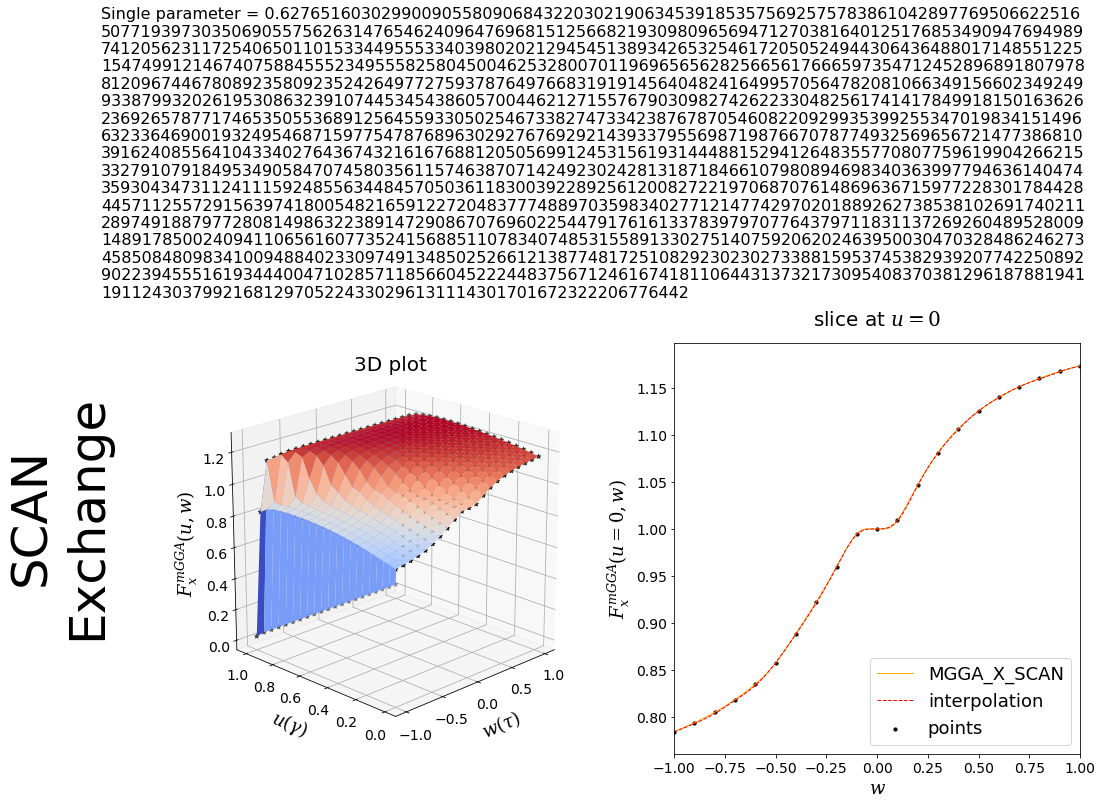


Total interpolation error = 0.0307947


In [13]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["figure.figsize"] = [16,12]

import textwrap
fig = plt.figure()

fig.suptitle("\n".join(textwrap.wrap(str('Single parameter = {}'.format(decimalInitial)), width = 100,subsequent_indent='   ')),  x=0.05, y=0.99, ha='left', wrap=True, size=16)
fig.subplots_adjust(top=0.6)

fig.text(0.05, 0.4, "SCAN\nExchange", ha='center', rotation=90, size=50, Wrap=True)


ax = fig.add_subplot(1,2,1, projection='3d')
surf = ax.scatter(X, Y, Z, color='black', marker='*')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')


ax.zaxis.set_rotate_label(False)
ax.view_init(20,-135)

ax.set_xlabel('\n'r'$w(\tau)$')
ax.xaxis.set_label_coords(100, 0)

ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_ylabel('\n'r'$u(\gamma)$')
ax.set_zlabel(r'$F_{x}^{mGGA}(u,w)$''\n',rotation=90)
#ax.set_zlim(bottom=0,top=15)
ax.set_title('3D plot',size=20)


#Plot the interpolation vs the functional and the original points
plt.subplot(1, 2, 2)
plt.scatter(xaxis, y1dOR, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnew,fk,  color='orange', lw=1, zorder=1, label=functional)
plt.plot(xnew,interp(xnew), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.legend(loc = 'lower right')
plt.xlim(-1,1)
if rescale==True:
    plt.ylim(0.9,4)

plt.title('slice at $u=0$',y=1.03,size=20)
plt.xlabel('$w$')
plt.ylabel(r'$F_{x}^{mGGA}(u=0,w)$')


#plt.savefig('mGGA_SCAN_X.png',dpi=480,bbox_inches="tight")
plt.show()


#Calculate the interpolation error on the finer grid
interpErr=[]
for sss in range(intrange):
    interpErr.append(abs((fk[sss] - interp(-1+(2*sss/(intrange-1))))/fk[sss]))

totinterr=sum(interpErr)/npoints;
  
print('\nTotal interpolation error = %g' % totinterr)

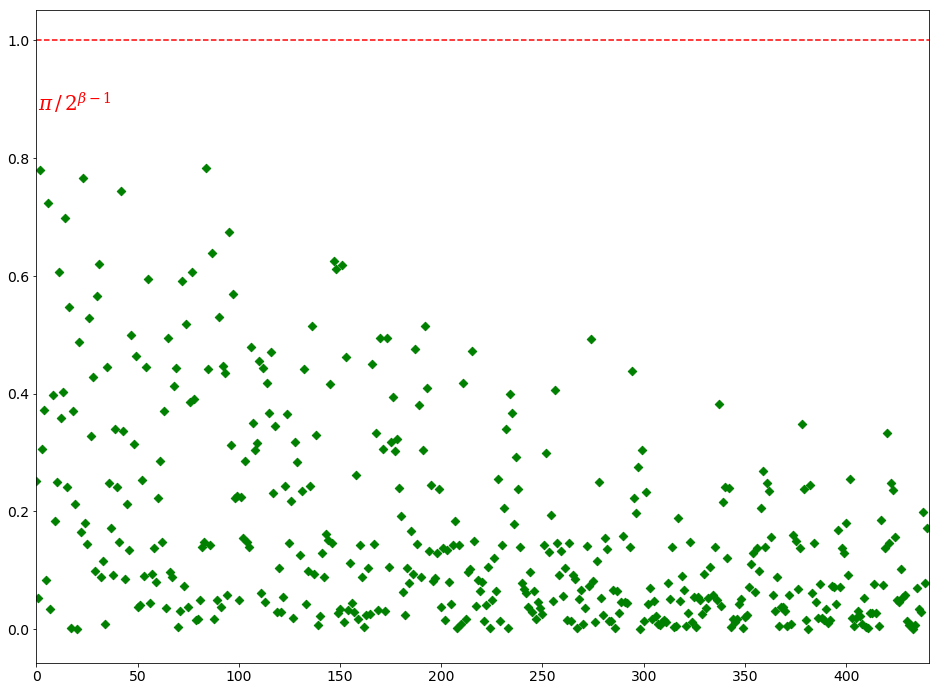

Total MaxError on the full 3D set = 3.52131


In [11]:
#Analyze the error
MaxError=np.pi/ 2 ** (beta - 1)

Errors = [abs(decodedValue - dataPoint)
                    for decodedValue, dataPoint in zip(decodedValues, xs)]
error=sum(Errors);
maxerror=max(Errors);
normalizedErrors = [abs(decodedValue - dataPoint)/MaxError
                    for decodedValue, dataPoint in zip(decodedValues, xs)]


xaxisforerr=[]
for x in range(len(xxs)):
    xaxisforerr.append(x);

plt.scatter(xaxisforerr, normalizedErrors, color='green', marker='D')
plt.hlines(1, 0,len(xxs), color='red', linestyle='dashed')
plt.text(0.75,0.88, r'$\pi \, / \, 2^{\beta - 1}$', fontsize=20, color='r')
plt.xlim(0,len(xxs))
plt.show()

mxaverr=sum(normalizedErrors)/len(xxs)**(1/2)
print('Total MaxError on the full 3D set = %g' % mxaverr);

In [12]:
#Final printout
#totinterr is the normalized interpolation error (normalized by the total number of points in the grid)
# this is mostly affected by the npoints parameter
totinterr=sum(interpErr)/npoints;
#totencerr is the normalized error of the encoder rescaled back to the original y range (using a pessimistic multiplication by the max value in the range, so this is really an upper bound to the error)
# this is mostly affected by the beta parameter
totencerr=sum(Errors)*max(y1dOR);
#toterr is the sum of the previous errors, which is a good indication of the success of the procedure
toterr=totinterr+totencerr;


print('Functional = %s' % functional)
print('Single parameter = {}'.format(decimalInitial))

if rescale == True:
    print('\nWarning: this xc functional diverges at s=infinity. The errors might be affected, even if a patch was applied! Use caution when interpreting the next results.')

print('\nnpoints = %d' % npoints)
print('Interpolation error = %g' % totinterr)
print('\nbeta = %d' % beta)
print('Encoder error = %g' % totencerr)
print('\nTotal error = %g' % toterr)

Functional = MGGA_X_SCAN
Single parameter = 0.627651603029900905580906843220302190634539185357569257578386104289776950662251650771939730350690557562631476546240964769681512566821930980965694712703816401251768534909476949897412056231172540650110153344955533403980202129454513893426532546172050524944306436488017148551225154749912146740758845552349555825804500462532800701196965656282566561766659735471245289689180797881209674467808923580923524264977275937876497668319191456404824164995705647820810663491566023492499338799320261953086323910744534543860570044621271557679030982742622330482561741417849918150163626236926578771746535055368912564559330502546733827473342387678705460822092993539925534701983415149663233646900193249546871597754787689630292767692921439337955698719876670787749325696567214773868103916240855641043340276436743216167688120505699124531561931444881529412648355770807759619904266215332791079184953490584707458035611574638707142492302428131871846610798089469834036399779463614047435